In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

# Intro to the Data
Here I will dive into the data, taking a preliminary look to identify what kind of data we have and what data is missing. I will also explain what each feature means, the basics of how the data was collected, and what methodologies were used to collect it.

In [2]:
df = pd.read_csv('cancer_data.csv')
print(df.shape)
print(df.head())

(559, 41)
  yearrt      med   maxeso  gender intake_who  age chemo  ott chemo3g gtv1  \
0   2010  17.0346  44.8989       0          2   67     1   21       2        
1   2014                         0          1   69         36                
2   2010                         1          1   82         24                
3   2013  17.2298  48.9217       1          1   77     1   36       2        
4   2013                         1          2   83         28                

        ...       CumultativeTotalTumorDose meanlungdose  lungv20 CumOTT  \
0       ...                           45.00      15.4178  33.8485     21   
1       ...                           67.00                           36   
2       ...                           52.25                           24   
3       ...                           69.00      25.0428  11.9888     36   
4       ...                           72.00                           28   

  OverallBaselineDysp OverallPostRTDyspFullScore DyspGT2 DeltaDy

Currently, all missing values are recorded as a space so I will convert them to NaN then take a look at how many entries there are for each feature.

In [3]:
df = df.replace(r'\s+', np.nan, regex=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559 entries, 0 to 558
Data columns (total 41 columns):
yearrt                        553 non-null object
med                           352 non-null object
maxeso                        352 non-null object
gender                        559 non-null int64
intake_who                    541 non-null object
age                           559 non-null int64
chemo                         451 non-null object
ott                           559 non-null int64
chemo3g                       451 non-null object
gtv1                          3 non-null object
tumorload                     331 non-null object
toxeso                        547 non-null object
toxesohigh2                   547 non-null object
pretoxeso                     551 non-null object
dose per fraction             233 non-null object
fractions                     233 non-null object
total dose                    233 non-null object
second dose per fracion       72 non-null object
s

Most features have at least 450 of a total possible 559 observations, which should be sufficient. One category, GTV1, has only 3 entries. This might make the category useless for our final predictive model. Four other categories have under 100 observations: second dose per fraction, second fractions, second total dose, and packs per day. The first 3 of those are all correlated to eachother, so it is unlikely that all 3 of these are necessary for the final model. Packs per day is directly related to smoking status, so this may not be a crucial feature either.<br>

In [4]:
print(df['TwoYearSurvival'].value_counts())

0    339
1    220
Name: TwoYearSurvival, dtype: int64


For Two Year Survival, our outcome of interest, there are 339 instances of die and 220 for live. This is fairly even and should not cause significant class imbalance in our predictive models.<br><br>

Currently, 0 represents death and 1 represents life. We will find later that death is actually the outcome of interest that we are trying to optimize for, so I will switch these values now. From this point forward, 0 represents life and 1 represents death.

In [5]:
df['TwoYearSurvival'].replace([0],['temp'],inplace=True)
df['TwoYearSurvival'].replace([1],[0],inplace=True)
df['TwoYearSurvival'].replace(['temp'],[1],inplace=True)

Now, to look at each individual feature.

In [6]:
df = df.apply(pd.to_numeric, errors="coerce")

for column in df:
    df.index.name = column
    print(df.index.name)
    print(f'Minimum: {df[column].min()}')
    print(f'Maximum: {df[column].max()}\n')

yearrt
Minimum: 2007.0
Maximum: 2014.0

med
Minimum: 2.6862
Maximum: 49.0148

maxeso
Minimum: 7.0901
Maximum: 79.2183

gender
Minimum: 0
Maximum: 1

intake_who
Minimum: 0.0
Maximum: 4.0

age
Minimum: 33
Maximum: 90

chemo
Minimum: 0.0
Maximum: 1.0

ott
Minimum: 1
Maximum: 96

chemo3g
Minimum: 0.0
Maximum: 2.0

gtv1
Minimum: 4.92
Maximum: 61.94

tumorload
Minimum: 0.9813
Maximum: 1075.4356

toxeso
Minimum: 0.0
Maximum: 4.0

toxesohigh2
Minimum: 0.0
Maximum: 1.0

pretoxeso
Minimum: 0.0
Maximum: 3.0

dose per fraction
Minimum: 1.5
Maximum: 7.5

fractions
Minimum: 4.0
Maximum: 44.0

total dose
Minimum: 7.2
Maximum: 129.6

second dose per fracion
Minimum: 1.5
Maximum: 10.0

second fractions
Minimum: 1.0
Maximum: 30.0

second total dose
Minimum: 2.0
Maximum: 45.0

BED
Minimum: 8.496
Maximum: 315.0

Modality
Minimum: 0.0
Maximum: 2.0

PacksPerDay
Minimum: 0.0
Maximum: 2.0

SmokingStatus
Minimum: 0.0
Maximum: 2.0

IsSCLC
Minimum: 0
Maximum: 0

T_stage
Minimum: 0.0
Maximum: 3.0

N_stage
Minimum

# Features

Yearrt: the year that the patient received radiation therapy. 2007-2014. <br>

Med: Mean Esophageal Dose. 2.6862-49.0148 Gy. <br>

Maxeso: maximum dose received by any point of the esophagus. 7.0901-79.2183 Gy.<br>

Gender: gender of the patient. 0/1.<br>

Age: age of the patient. 33-90 years.

Chemo: whether or not the patient received chemotherapy. 0/1. <br>

OTT: Overall Treatment Time. 1-96 months.<br>

Chemo3g: Timing of chemotherapy with radiation. 0 = only radiotherapy. 1 = sequential chemoradiation. 2 = concurrent chemoradiation. <br>

GTV1: Initial gross tumor volume. Defined as the enhancing lesion and surrounding edema as visualized in diagnostic CT Scan. 4.92-61.94 cc (cubic centimeters).<br>

Tumorload: Refers to the number of cancer cells, the size of a tumor, or the amount of cancer in the body. Also called tumor burden. Can be measured with ELISA or beta-gal immunoassay. 0.9813-1075.4356.<br>

Toxeso: Esophageal toxicity resulting from radiation. 0, 1, 2, 3, 4. Mostly dependent on maxeso and schedule of radiation therapy. Can negatively impact long term survival. Less common when given separately from chemotherapy. Level 3/4 is considered severe.<br>

Toxesohigh2: Whether esophageal toxicity score was above 2. 0/1. <br>

Pretoxeso: Esophageal toxicity before radiotherapy. 0, 1, 2, 3.<br>

Dose per fraction: Amount of Gy per radiation course. Standard of care is 2 Gy/fraction, 5 fractions/week for total 60 Gy. 1.5-7.5.<br>

Fractions: Number of total radiation treatments over the treatment period. 4-44.<br>
Total Dose: Total amount of Gy for entire treatment course. 7.2-129.6.<br>

Second Dose per Fraction: In some cases, two fractions per day are used near the end of a course of treatment (hyperfractionation). Used on tumors that regenerate more quickly when they are smaller. Only 72 patients received this. 1.5-10.<br>

Second Fractions: The number of fractions in the treatment regimen that were given as the second fraction of the day? First fraction destroys cells in mitosis. Second fractions destroys cells entering mitosis. 1-30.<br>

Second Total Dose: Seems like this might be the total amount of Gy given in all second doses. 2-45.<br>

BED: Biologically Effective Dose, dependent on linear quadratic cell survival. 8.496-315.<br>

Modality: Type of treatment. 0 = 3D CRT (3D conformal radiotherapy). 1 = VMAT/IMRT (Volumetric Modulated Arc Therapy/Intensity Modulated Radiation Therapy). <br>

PacksPerDay: Number of cigarette packs smoked per day, as estimated by the patient. 0-2.<br>

SmokingStatus: Not a smoker, occasional smoker, regular smoker. 0,1,2.<br>

IsSCLC: This study is on Non-small cell lung cancer, so I find it unusual that they included a category on whether the patient has small cell lung cancer. All entries are 0.<br>

T Stage: TNM system describes characteristics of NSCLC after treatment. T is for tumor size. T0=no sign of cancer. T1=tumor is contained within lung. T2=tumor is 3-5 cm or reaches into bronchus or visceral pleura. T3=tumor is 5-7 cm or reaches into chest wall, phrenic nerve, or pericardium. T4=over 7 cm or reaches into second lung, diaphragm, other surrounding areas.<br>

N Stage: N is for Node, and whether cancer has spread to lymph nodes. N0=lymph node is non-cancerous. N1=cancer cells in area where lungs join lymph nodes. N2=cancer in lymph nodes within affected chest area. N3=cancer in lymph nodes outside affected chest area.<br>

M Stage: M is for metastasis, when the cancer spreads to another part of the body. M0=cancer has not spread outside initial area. M1=cancer has spread. All 0 in this cohort.<br>

PA: ??? Binary.<br>

Locatie: Location of tumor. 0,1,2,3.<br>

FEV: Forced Expiratory Volume. The maximum volume of air breathed out in 1 second. This is impaired when pulmonary function is reduced due to disease burden. 25-138.<br>

CumulativeTotalTumorDose: 1.5-129.6. There is another category called Total Dose that ranges from 7.2-129.6. That category only has 233 observations, and this cateogry has 559 so I will keep this one.<br>

Mean Lung Dose: The mean amount of radiation delivered to the lung for all doses/fractions. 1.5949-34.6335 Gy. 15-20 Gy is average.<br>

Lungv20: Percentage of lung volume receiving radiation doses of 20 Gy or more. If too high, patient experiences pneumonitis. Under 33% is considered safe, under 22% is considered very little risk. 0-50.9581.<br>

CumOTT: Cumulative Overall Treatment Time. 1-96 months. This confirms to me that some features are redundant due to multiple sources of data being combined. This feature is unnecessary. <br>

OverallBaselineDysp: Dyspnea is difficult or labored breathing. Dypsnea score befoe treatment. ? 0-3 out of possible 5.<br>

OverallPostRTDyspFullScore: Dypsnea after treatment. 0,1,2,3,4,5.<br>

DyspGT2: Whether or not the dyspnea score is greater than 2. Binary. <br>

DeltaDyspGel: This is most likely the change in dyspnea score from before and after treatment. <br>

TreatmentType: ??? Only 2 in this cohort.<br>

TwoYearSurvival: Whether or not the patient survived 2 years after starting radiation therapy treatment. 0 is now survive, 1 is die.

# Intro

This data comes from a 2017 study of historical patient data from 2 cohorts of of non-small cell lung cancer patients treated with (chemo)radiotherapy. This includes 559 patients at the Maastro clinic in the Netherlands, and 139 at the University of Manchester, UK. However, only the data fram the first cohort at Maastro clinic has been made publicly available. The original authors, Arthur Jochems et. al, used this data to develop a predictive model for patient survival using a Bayesian network. Tney validated it using testing data from a 3rd cohort from University of Michigan.<br>

Recent research has illuminated several features that have an effect on patient prognosis. These include performance status, weight loss, presece of comorbidity, chemotherapy in combination with radiation, dose of radiation, size of tumor, features derived from tumor imaging data, and the radiomics approach. Despite these numerous factors, the TNM system of classification is widely regarded as the most valuable feature predictor for patient survival. The TNM system describes the size of the tumor, the severity of lymphatic involvement, and whether the cancer has metastasized to other parts of the body beyond the initial site of malignancy. Typically, TNM is evaluated by the doctor using a defined set of guidelines *following surgical tumor resection*. In this study, TNM was evaluated by the doctor at the end of each patient's non-invasive CRT or RT treatment regimen. Because the TNM system for NSCLC was designed with surgery in mind, the observations derived from a non-invasive treatment modality may not have the same predictive power. In fact, studies have indicated that the TNM system performs poorly for patients receiving CRT or RT.

Amongst the 41 features in this study, select few features have a complete or near complete representation of the entire cohort. Thorough data is provided for the year of treatment, age, gender, overall treatment time, whether the patient received chemotherapy as well as radiation, esophageal toxicity and pretoxicity, modality, smoking status, TNM classification measures, PA, locatie, cumulative tumor dose, level of dyspnea before and after treatment, dyspGT2, deltadyspgel, and two year survival. While the amount of missing data for other categories may prove to be a obstacle for evaluating this dataset, we should note that we have a significant amount of data available for our two most relevant features: TNM classification and the outcome, two year survival.


The data was collected as part of an IRB-approved and registered clinical trial. Patients with inoperable NSCLC were treated between 2007 to 2014. The patients received different schedules of dosing for their radiation, and some were treated with chemotherapy at different points in their treatment. 189 patients were treated using sequential CRT, completing a chemotherapy schedule before starting radiation at a cumulative dose of 54.0 to 79.2 Gy (fractions of 1.8 Gy, twice daily, until the mean lung dose or maximum dose to the spinal cord was reache)d. 283 patients were treated using concurrent CRT, receiving chemotherapy and radiation at the same time at a cumulative dose of 45 Gy (fractions of 1.5 Gy, twice daily). This treatment was followed by an individualized dose ranging from 8 to 24 Gy (fractions of 2.0 Gy, once daily, until the normal tissue dose constraints were reached). The remaining patients received an individualized regimen, some receiving conformal RT with and without chemotherapy.

# Thesis

Given that the TNM classification is the gold standard in survival risk stratification, I hypothesize that these will be the strongest indicator of patient survival, even though they weren't designed for inoperable patients. Instinctively, I would also hypothesize that smoking status has an effect on survival, because smoking will directly interfere with the treatment regimen and aggravate the cancer.<br>

Initial gross tumor volume (GTV1) and tumor load also look like they will reveal a significant relationship with the outcome. They are both directly related to the Tumor part of TNM classification, which I hypothesize will be the strongest set of indicators. All 3 of these features are derived from tumor size, so they may not individually provide enough unique information and may actually end up complicating the model.<br>

I don't expect any information related to dosing quantity or schedule to have much effect on patient survival because every patient has such vastly different needs, background, and reactions to medication.<br>

Forced Expiratory Volume (FEV) is a valuable indicator for impaired pulmonary function and thus disease burden. However, I don't expect this feature to have much significance for the outcome because each patient has a different starting lung capacity. If this feature were change in forced expiratory volume over time, that would be a much more useful feature.<br>

Add bulletpoints summary.

# Exploratory Analysis

Be sure to explain the intuition behind why you're looking into a particular part of the data, or trying to use certain types of models for the survival prediction. e.g. there are a lot of features, many of which might not be useful, so I'll initially use Lasso regression to train a basic model and drop unneeded features at the same time. And have some (very) basic discussion on the results.

In this section I will start looking at correlations, visualizations of the data, and run a few machine learning classifiers.

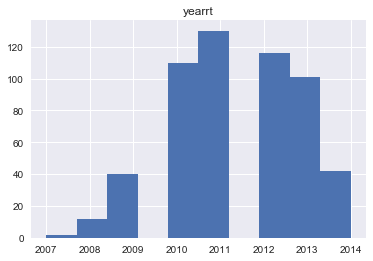

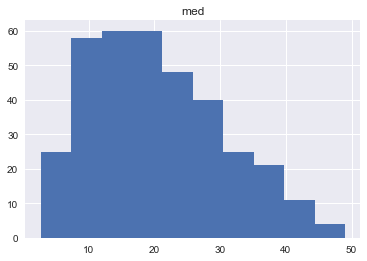

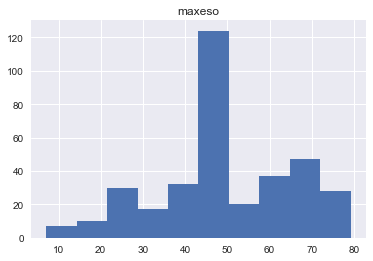

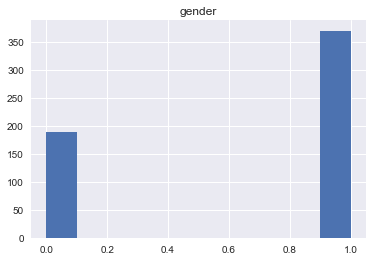

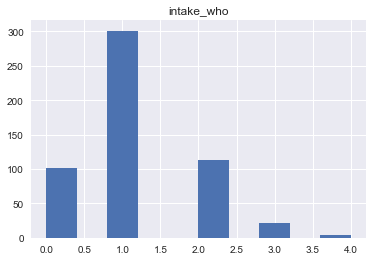

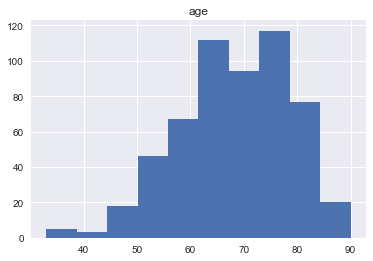

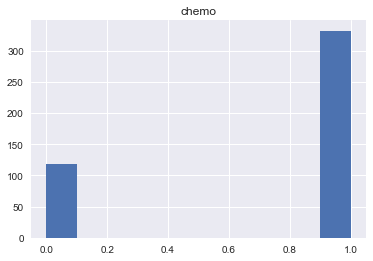

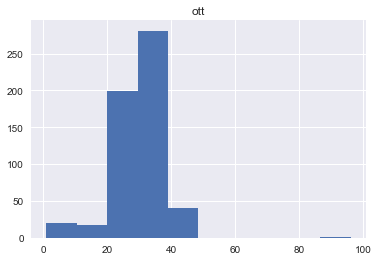

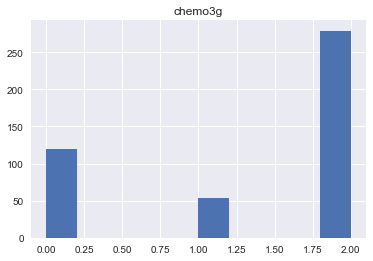

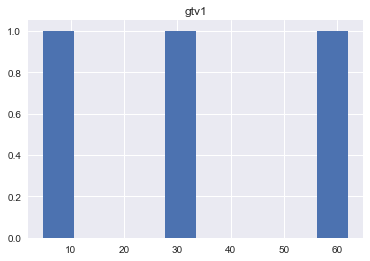

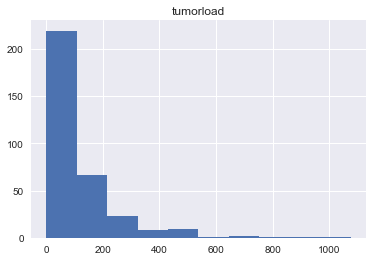

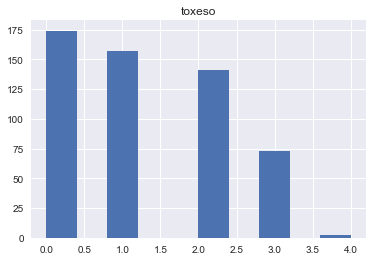

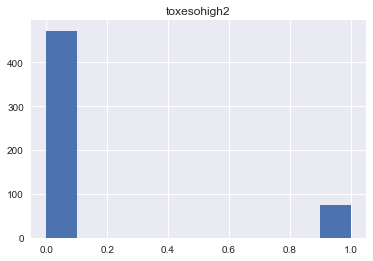

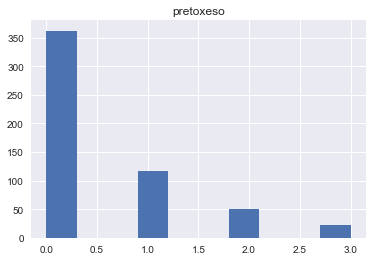

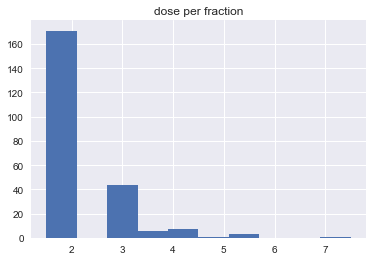

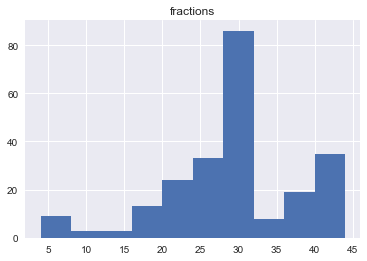

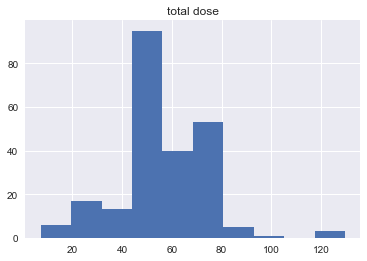

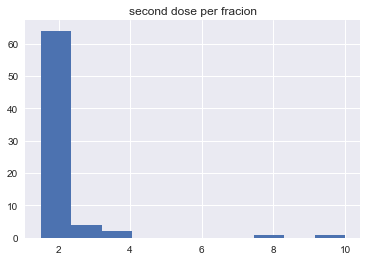

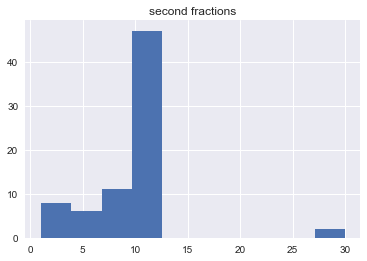

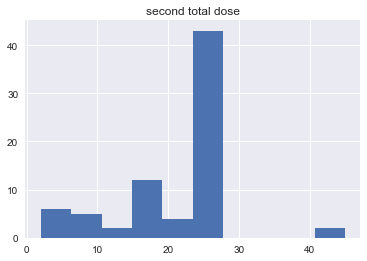

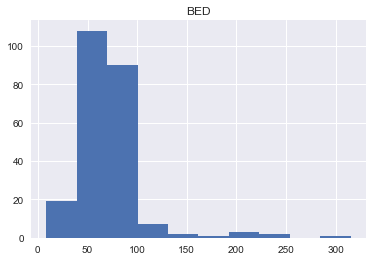

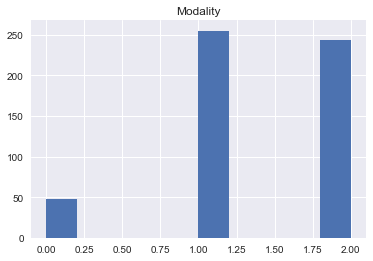

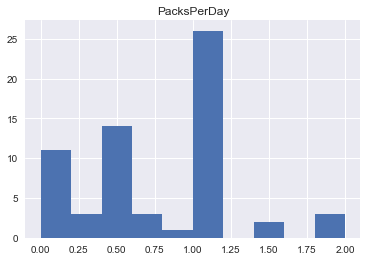

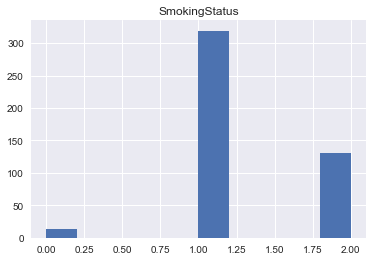

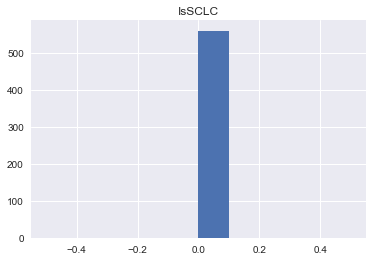

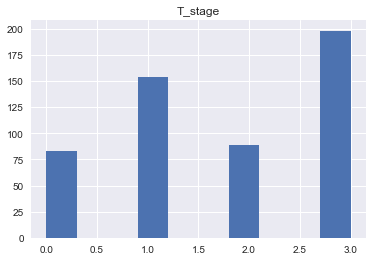

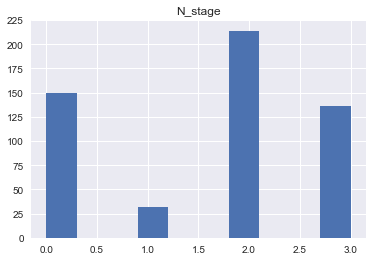

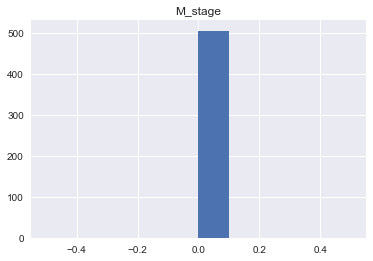

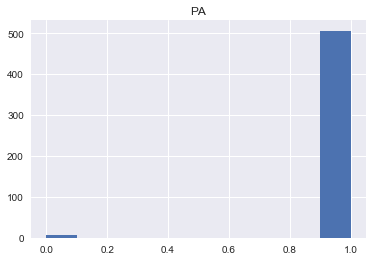

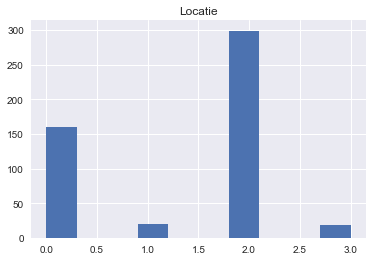

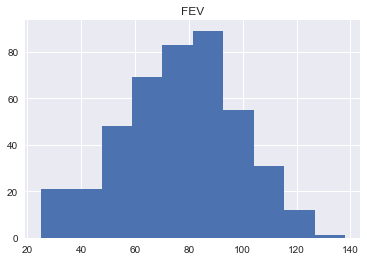

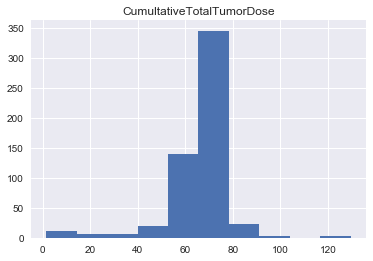

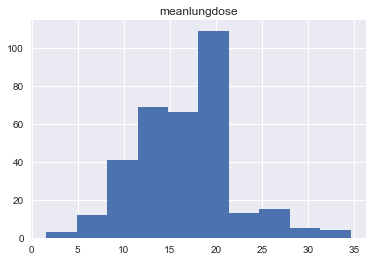

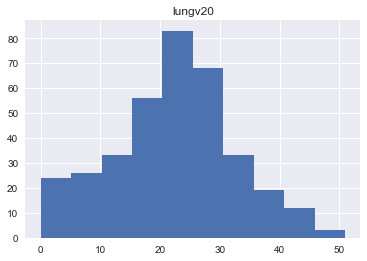

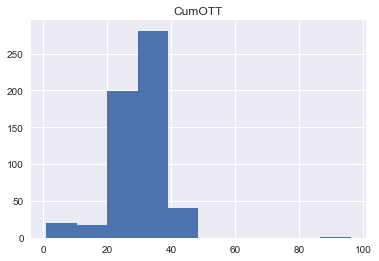

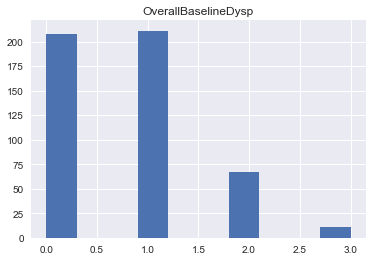

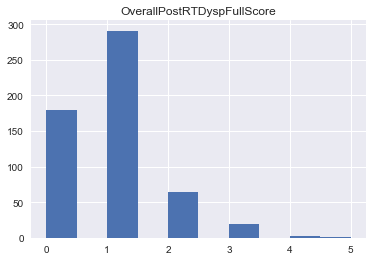

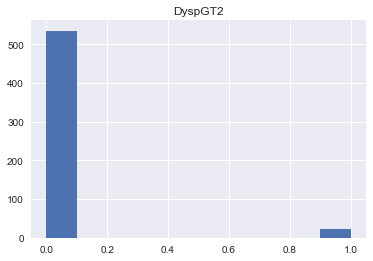

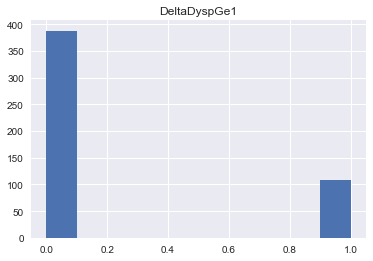

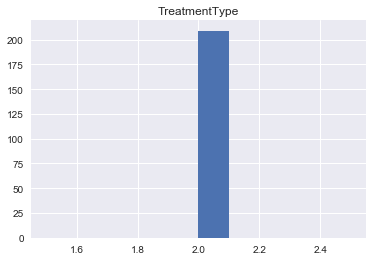

In [7]:
input = df.drop(['TwoYearSurvival'], axis=1)

for column in input:
    plt.hist(input[column].dropna())
    plt.title(column)
    plt.show()

There are more patients in the more recent years of the study. These patients may end up living longer since they are being treated with more state of the art technology. While this may skew the data towards survival, technology is always improving, and we would likely see survival improve with time in most medical data sets. In this study, since all patients are undergoing the standard NSCLC protocol, we may not see that year of treatment has any effect on survival.<br>

There is a relatively normal age distribution, with the majority of patients ranging from 65-75. More people received chemotherapy than did not receive chemotherapy. Although the overall treatment time ranges from 1-96 months, there is only one observation at 96 months; the rest of the patients fall under 50 months, which is about 4 years.<br>

GTV1 might have been a good feature if it had more than 3 datapoints. The tumorload has a near exponential decrease, which means that most patients have a relatively low tumor load.<br>

The toxeso histogram shows that zero esophageal toxicity is most common, with high numbers of patients at levels 1 and 2 as well. Few patients have severe toxicity at 3, and only 1 patients has level 4.<br>

The dose per fraction also maxes out at the beginning. From a medical perspective, the lower the dose the better, only the minimum biological effective dose should be used to help prevent side effects and complications. The same trend is seen in second dose per fraction. The number of total fractions given is more varied; it peaks, drops, and rises again. The same trned is seen in total dose.<br>

For people who smoke, the common quantity to consume is 1 pack per day. The next most common quantity is 1/2 pack per day, and shortly behind that is 0 packs (non-smokers).<br>

There is a healthy distribution of values for both T and N classifications, which will help to build a reliable model. There is, however, only 1 value for the M classification, so this feature will likely not make the cut in the final model.<br>

FEV has a near perfect normal distribution, which may make it a good feature to include.

Cumulative total tumor dose has a much more normal distribution than total tumor dose, which makes sense because it has over double the number of observations. The normal distribution might make this another good feature to include.<br>

Lungv20 has a normal distribution as well. This makes intuitive sense because this metric should be targeted to deliver as much medicine to the lungs as possible, but if too much is given the patient will develop pneumonitis. The distribution should therefore be centered around the middle.<br>

More patients tended not to have dyspnea at baseline, with the majority of values falling at 0 or 1. The patients that did have dyspnea likely started with a stronger disease burden, which may correlate to their survival. <br>

The variables with normal distributions are age, FEV, Cumulative Total Tumor Dose, and lungv20. We will keep these in mind when moving forward.

In [8]:
corrmat = df.corr()
print(corrmat['TwoYearSurvival'])

yearrt                        0.198887
med                           0.124601
maxeso                        0.104804
gender                        0.066701
intake_who                    0.102559
age                           0.067338
chemo                        -0.053787
ott                          -0.180136
chemo3g                      -0.044269
gtv1                               NaN
tumorload                     0.177023
toxeso                        0.093582
toxesohigh2                   0.073368
pretoxeso                    -0.032043
dose per fraction            -0.050494
fractions                    -0.091325
total dose                   -0.034500
second dose per fracion       0.022480
second fractions             -0.047052
second total dose            -0.098626
BED                          -0.049029
Modality                      0.062833
PacksPerDay                   0.119660
SmokingStatus                -0.037060
IsSCLC                             NaN
T_stage                  

The strongest covariance with outcome is -0.199, -0.177 for yearrt and tumorload. Yearrt is Year of RT, which means the year of receiving radiation therapy (RT). I would imagine that the higher the year, the more advanced the technology, and the higher then 2-year survival. However, the correlation is negative. Despite being the strongest relationship of the group, -0.199 is not very strong. We should keep in mind that patients are still undergoing standard treatment protocols, some of which were established in 2005. Advancements in medical technology may not be employed here, and the decrease in survival through the years may be attributed to something else such as change in staff.

# Classification Models

The evaluation measure I have chosen is a combination between precision and recall. The most common cross-validation score is a measure of accuracy. However, simple accuracy is not the best measure when predicting human lives, since the cost of a wrong prediction is literally a matter of life and death. A prediction of life when the outcome is death would prevent that person and their familiy from being able to adequately prepare themselves for the future, and this should be avoided at all costs.<br>

For this reason, I chose to look at the combination of precision and recall in a custom f-score. Precision is the number of true positives over the number of true positives plus false postives. This means we are considering the number of accurately predicted deaths out of all predicted deaths. Recall is the number of true positives over the number of true positives plus false negatives. This means that we are considering the number of accurately predicted deaths out of all total deaths.

Essentially, precision measures the ability to identify real deaths against false-alarm deaths. The people who slip through the cracks end up living longer than expected. Recall measures the ability to predict death correctly against predicting life incorrectly. The people who slip through the cracks are the ones who die unexpectedly and without a chance to prepare. Since this consequence is more severe, I will choose a beta value that places more weight on recall than precision.<br>

Precision measures expected deaths vs. unexpected survival. The people who slip through the cracks end up living longer than expected.
Recall measures expected deaths vs. unexpected deaths. The people who slip through the cracks are the ones who die unexpectedly and without a chance to prepare.


However, when recall is favored too strongly, the models with the highest scores tend to aggressively predict death and lose out on predicting positives well.


TP: people who we said died and died
FP: people who we said died but lived
Precision: TP / TP + FP (number of real deaths out of all predicted deaths)
Recall: TP / TP + FN (number of predicted deaths out of all real deaths)

"precision -- the ability to identify positives as positives
recall -- the ability to not to identify negatives as positives"
explain?

In [9]:
df = df.fillna(df.mean())
X = df.loc[:, ~(df.columns).isin(['TwoYearSurvival'])]
Y = df['TwoYearSurvival']

from sklearn.model_selection import cross_validate

def recall_score(model, X, Y):
    scores = cross_validate(model, X, Y, cv = 5, scoring = ['accuracy','recall'])
    test_accuracy = scores["test_accuracy"].mean()
    test_recall = scores["test_recall"].mean()
    train_accuracy = scores["train_accuracy"].mean()
    train_recall = scores["train_recall"].mean()
    
    print(f'Cross Validation Test Accuracy: {test_accuracy}')
    print(f'Cross Validation Test Recall: {test_recall}')
    print(f'Cross Validation Train Accuracy: {train_accuracy}')
    print(f'Cross Validation Train Recall: {train_recall}\n')
    
    score = (0.5*test_recall) + (0.5*test_accuracy)
    print(f'Combined Score: {score}\n')
    return score

In [119]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

ftwo_scorer = make_scorer(fbeta_score, beta=.75)

def recall_score(model, X, Y):
    scores = cross_validate(model, X, Y, cv = 5, scoring = ftwo_scorer)
    train_ = scores['train_score'].mean()
    test_ = scores['test_score'].mean()
    print(f'Training Score: {train_}')
    print(f'Testing Score: {test_}\n')
    
    pred_y = model.predict(X)
    cm = pd.crosstab(Y, pred_y)
    print(cm)
    
    accuracy = cross_val_score(model, X, Y, cv=5).mean()
    
    if cm.shape != (2,2):
        cm[2] = 0
        print(cm)
    else:    
        true_neg_p = cm[0][0]/(cm[0][0] + cm[1][0])
        true_pos_p = cm[1][1]/(cm[1][1] + cm[0][1])
        
        print(f'Negative Accuracy: {true_neg_p}')
        print(f'Positive Accuracy: {true_pos_p}')
        print(f'Cross-Val Accuracy: {accuracy}\n')
        
    score = (test_ + accuracy)/2
    print(f'Combined Score: {score}\n')
        
# the problem here is that the position 1 column is named "1" so if I try to make a new column for the new 0 values
# in its correct position 1 spot it overrides those values and we get only 0 no new columns
# but if I add it at the end as position 2 then it names the column 2 so I can't access it in my true_neg formula

    return score
    
# Also, it's annoying to search through all my features using both cross-val pos/neg accuracy and f1score.
# Can i average them?

# Lasso Regression

Since there are many features (41 to be exact) I will first perform lasso regression with L1 regularization to do an initial round of feature reduction. To account for missing data, I will fill all NaN values with averages for their respective columns. There are only 559 observations, so it is not practical to drop all observations with NaN values. The category GTV1 has only 3 observations, so if we dropped all NaN values we would only be left with 3 values. For lasso regression specifically, I care to see which features were dropped (coefficients reduced to 0). The model returns my coefficients as an array of 1 array, so I need to isolate the first element of that array to map the values to their respective features.

In [120]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

max_score = 0
best_alpha = 0

X = df.loc[:, ~(df.columns).isin(['TwoYearSurvival'])]
Y = df['TwoYearSurvival']

def change_regularization(alpha, pen):
    
    global max_score, best_alpha
    
    lr = LogisticRegression(C = alpha, penalty = pen)
    fit = lr.fit(X, Y)
    
    print(f'C = {alpha}\n')

    fit.coef_
    coeff = fit.coef_[0]
    
    for i in range(len(coeff)):
        print(X.columns.values[i], coeff[i])
    print(fit.intercept_)
    print('\n')
    
    score = recall_score(lr, X, Y)
    
    if score > max_score:
        max_score = score
        best_alpha = alpha
    
alpha_nums = [0.0001, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 1, 100, 1000, 1e5, 1e7, 1e9]

for alpha in alpha_nums:
    change_regularization(alpha, 'l1')

C = 0.0001

yearrt 0.000196654706733
med 0.0
maxeso 0.0
gender 0.0
intake_who 0.0
age 0.0
chemo 0.0
ott 0.0
chemo3g 0.0
gtv1 0.0
tumorload 0.0
toxeso 0.0
toxesohigh2 0.0
pretoxeso 0.0
dose per fraction 0.0
fractions 0.0
total dose 0.0
second dose per fracion 0.0
second fractions 0.0
second total dose 0.0
BED 0.0
Modality 0.0
PacksPerDay 0.0
SmokingStatus 0.0
IsSCLC 0.0
T_stage 0.0
N_stage 0.0
M_stage 0.0
PA 0.0
Locatie 0.0
FEV 0.0
CumultativeTotalTumorDose 0.0
meanlungdose 0.0
lungv20 0.0
CumOTT 0.0
OverallBaselineDysp 0.0
OverallPostRTDyspFullScore 0.0
DyspGT2 0.0
DeltaDyspGe1 0.0
TreatmentType 0.0
[ 0.]


Training Score: 0.7065440753090937
Testing Score: 0.7065392623615258

col_0              1
TwoYearSurvival     
0                220
1                339
col_0              1  2
TwoYearSurvival        
0                220  0
1                339  0
Combined Score: 0.6564871343982661
C = 0.0001

yearrt 0.000196654706733
med 0.0
maxeso 0.0
gender 0.0
intake_who 0.0
age 0.0
chemo 0.0


In [121]:
print(f'Maximum Score: {max_score}')
print(f'Lambda: {best_alpha}\n')

Maximum Score: 0.6564871343982661
Lambda: 0.0001



I have used cross-validation with 5 folds because it is computationally cheap, but creates enough diversity amongst models to protect against overfitting.<br>

When the regularization coefficient is too low, the model eliminates features very aggressively and ends up predicting death for every patient. This gives the model good positive accuracy, but horrible negative accuracy. The most commonly used feature is year of treatment, with tumorload next. I wouldn't have expected the year of treatment to be more important than direct medical indicators, but it was also one of the features that revealed strong covariance with the outcome in the correlation matrix. The next features that get included are age and overall treatment time, which have a positive and negative correlation with the outcome.<br>

When regularization is not used, we see a smaller gap between negative and positive accuracy. It seems that regardless of the beta value, the closest we can get is 49% negative accuracy and 82% positive accuracy. Balanced with a testing F1-score of 68%, this model is sufficient but not impressive. This model also has a training score of 75%, which means it is overfitting.
FINAL SCORE: 65.6%.


** Best Beta to use?

# Ridge Regression

In [122]:
max_score = 0
best_alpha = 0

alpha_nums = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.3, 0.5, 1, 100, 1000, 1e5]

for alpha in alpha_nums:
    change_regularization(alpha, 'l2')

C = 1e-07

yearrt 0.000193316821271
med 2.19709060673e-05
maxeso 3.24480570847e-05
gender 8.93243652744e-07
intake_who 2.17765560022e-06
age 2.59439645124e-05
chemo -4.69851288725e-07
ott -3.6008769401e-05
chemo3g -7.63455941076e-07
gtv1 2.927338341e-06
tumorload 0.000361310483853
toxeso 2.70587418845e-06
toxesohigh2 6.76384496749e-07
pretoxeso -6.74873337556e-07
dose per fraction -2.65485330863e-07
fractions -6.07775588772e-06
total dose -1.58643872607e-06
second dose per fracion 3.08428920435e-07
second fractions 1.58720921685e-07
second total dose -7.22469925478e-07
BED -1.18471093217e-05
Modality 1.19114468649e-06
PacksPerDay 2.40321443665e-07
SmokingStatus -2.93150468254e-07
IsSCLC 0.0
T_stage -2.62357164328e-07
N_stage 4.16590827546e-06
M_stage 0.0
PA 1.60044168007e-07
Locatie -8.41127299153e-07
FEV -4.18319441396e-05
CumultativeTotalTumorDose -4.63938655015e-05
meanlungdose 9.79347950033e-06
lungv20 3.74329604131e-05
CumOTT -3.5949107858e-05
OverallBaselineDysp 7.2015981657e-07


In [124]:
print(f'Maximum Score: {max_score}')
print(f'Lambda: {best_alpha}\n')

Maximum Score: 0.6564871343982661
Lambda: 1e-07



Using ridge regression, we were able to obtain very similar results to lasso regression. Again, the models did better without regularization, which means very large parameter estimates are not penalized and makes the model prone to overfitting. With a negative accuracy of 48%, positive accuracy of 82%, and testing score of 67%, this model is slightly worse than the lasso model but not significantly different.
FINAL SCORE: 65.6%
NOTE: lambda is smaller here, regularization very strong (prevents overfitting)

Note: "Logistic regression good for time and memory requirement. It is not particularly affected by mild cases of multi-collinearity. Severe cases of multi-collinearity can be handled by implementing logistic regression with L2 regularization, although if a parsimonious model is needed, L2 regularization is not the best choice because it keeps all the features in the model."

# Decision Tree

In [125]:
from sklearn import tree
from sklearn.model_selection import cross_val_score
from IPython.display import Image, display
import pydotplus
import graphviz

max_score = 0
best_depth = 0
best_rand = 0
best_ftmax = 0
best_mnsplit = 0

input_features = ['yearrt', 'med', 'maxeso', 'gender', 'intake_who', 'age', 'chemo',
       'ott', 'chemo3g', 'gtv1', 'tumorload', 'toxeso', 'toxesohigh2',
       'pretoxeso', 'dose per fraction', 'fractions', 'total dose',
       'second dose per fracion', 'second fractions', 'second total dose',
       'BED', 'Modality', 'PacksPerDay', 'SmokingStatus', 'IsSCLC', 'T_stage',
       'N_stage', 'M_stage', 'PA', 'Locatie', 'FEV',
       'CumultativeTotalTumorDose', 'meanlungdose', 'lungv20', 'CumOTT',
       'OverallBaselineDysp', 'OverallPostRTDyspFullScore', 'DyspGT2',
       'DeltaDyspGe1', 'TreatmentType']

def run_decision_tree (depth_max, random, feature_max, min_split):
    
    global max_score, best_depth, best_rand, best_ftmax, best_mnsplit

    decision_tree = tree.DecisionTreeClassifier(
        criterion = 'entropy',
        max_depth = depth_max,
        random_state = random,
        max_features = feature_max,
        min_samples_split = min_split
    )
    decision_tree.fit(X, Y)

    dot_data = tree.export_graphviz(
        decision_tree, out_file=None,
        feature_names=input_features,
        class_names=['die','live'],
        filled=True
    )
    graph = pydotplus.graph_from_dot_data(dot_data)
    graphimage = Image(graph.create_png())
    #display(graphimage)
    
    print(f'Max Depth: {depth_max}, Random State = {random}, Max Feature = {feature_max}, Min Samples Split = {min_split}')
    
    score = recall_score(decision_tree, X, Y)
    
    if score > max_score:
        max_score = score
        best_depth = depth_max
        best_rand = random
        best_ftmax = feature_max
        best_mnsplit = min_split
        
#depth_maxs = [1,2,3,4,5]
#randoms = [1]
#feature_maxs = [1,2,3,4,5,6,7]
#min_splits = [2,3,4,5,6,7]

depth_maxs = [3,4,5]
randoms = [1]
feature_maxs = [4,5,6,7]
min_splits = [4,5,6,7]


for depth_max in depth_maxs:
    for random in randoms:
        for feature_max in feature_maxs:
            for min_split in min_splits:
                run_decision_tree (depth_max, random, feature_max, min_split)

Max Depth: 3, Random State = 1, Max Feature = 4, Min Samples Split = 4
Training Score: 0.7131175382233564
Testing Score: 0.6907629533362629

col_0            0    1
TwoYearSurvival        
0                8  212
1                0  339
Negative Accuracy: 0.03636363636363636
Positive Accuracy: 1.0
Cross-Val Accuracy: 0.5921492921492922

Combined Score: 0.6414561227427775
Max Depth: 3, Random State = 1, Max Feature = 4, Min Samples Split = 5
Training Score: 0.7131175382233564
Testing Score: 0.6907629533362629

col_0            0    1
TwoYearSurvival        
0                8  212
1                0  339
Negative Accuracy: 0.03636363636363636
Positive Accuracy: 1.0
Cross-Val Accuracy: 0.5921492921492922

Combined Score: 0.6414561227427775
Max Depth: 3, Random State = 1, Max Feature = 4, Min Samples Split = 6
Training Score: 0.7131175382233564
Testing Score: 0.6907629533362629

col_0            0    1
TwoYearSurvival        
0                8  212
1                0  339
Negative Accura

In [126]:
print(f'Highest Score: {max_score}')
print(f'Max Depth: {best_depth}')
print(f'Random State: {best_rand}')
print(f'Max Features: {best_ftmax}')
print(f'Min Samples Split: {best_mnsplit}')

Highest Score: 0.645692410346661
Max Depth: 5
Random State: 1
Max Features: 5
Min Samples Split: 7


The highest cross-val score achieved through a decision tree is 65%. Max Depth = 5, Random State = 1, Max Features = 5, Min Samples Split = 7. This is slightly worse than the scores achieved through logistic regression using ridge and lasso methods.
FINAL SCORE: 65%

# Random Forest

In [127]:
from sklearn import ensemble

max_score = 0
best_depth = 0
best_rand = 0
best_ftmax = 0
best_n = 0
best_mnsplit = 0

def run_random_forest(depth_max, feature_max, min_split, n, random):
    
    global max_score, best_depth, best_rand, best_ftmax, best_n, best_mnsplit

    #X_dummies = pd.get_dummies(X)
    rfc = ensemble.RandomForestClassifier(
        max_depth = depth_max,
        max_features = feature_max,
        min_samples_split = min_split,
        n_estimators = n,
        random_state = random
        )
    
    rfc.fit(X,Y)
    
    print(f'Max Depth: {depth_max}, Max Feature = {feature_max}, Number of Trees = {n}, Random State = {random}, Min Samples Split: {min_split}')
    
    score = recall_score (rfc, X, Y)
    
    if score > max_score:
        max_score = score
        best_depth = depth_max
        best_rand = random
        best_ftmax = feature_max
        best_n = n
        best_mnsplit = min_split

depth_maxs = [3,4,5]
randoms = [1]
feature_maxs = [4,5,6,7]
min_splits = [4,5,6,7]
ns = [10, 50, 100]

for depth_max in depth_maxs:
    for feature_max in feature_maxs:
        for min_split in min_splits:
            for n in ns:
                for random in randoms:
                    run_random_forest (depth_max, feature_max, min_split, n, random)

Max Depth: 3, Max Feature = 4, Number of Trees = 10, Random State = 1, Min Samples Split: 4
Training Score: 0.7455750234165068
Testing Score: 0.682798972256111

col_0             0    1
TwoYearSurvival         
0                44  176
1                16  323
Negative Accuracy: 0.2
Positive Accuracy: 0.9528023598820059
Cross-Val Accuracy: 0.5867760617760618

Combined Score: 0.6347875170160864
Max Depth: 3, Max Feature = 4, Number of Trees = 50, Random State = 1, Min Samples Split: 4
Training Score: 0.7451685512060562
Testing Score: 0.6914097166790939

col_0             0    1
TwoYearSurvival         
0                40  180
1                 8  331
Negative Accuracy: 0.18181818181818182
Positive Accuracy: 0.976401179941003
Cross-Val Accuracy: 0.5957368082368083

Combined Score: 0.6435732624579511
Max Depth: 3, Max Feature = 4, Number of Trees = 100, Random State = 1, Min Samples Split: 4
Training Score: 0.7495169324686687
Testing Score: 0.6867796353431516

col_0             0    1
Tw

In [129]:
print(f'Highest Score: {max_score}')
print(f'Max Depth: {best_depth}')
print(f'Random State: {best_rand}')
print(f'Max Features: {best_ftmax}')
print(f'Min Samples Split: {best_mnsplit}')

Highest Score: 0.6483992332173769
Max Depth: 3
Random State: 1
Max Features: 4
Min Samples Split: 5


The highest score using random forest is 0.6484. This was achieved using max_depth = 3, random_state = 1, max_features = 4, min_samples_split = 5. The score generally goes down as we use more features, and up as we increase the number of trees in the forest. The score is slightly higher than that of the best singular decision tree, which was 0.6456, but this is not a significant difference. It is important to note that this dataset has not optimized been optimized for the few categorical features, for which we may need to get dummies. Let's continue running through the models, then try them all again with dummy features added.
FINAL SCORE: 65%


# Support Vector Machines

In [130]:
from sklearn.svm import SVC

max_score = 0
best_alpha = 0
best_kernel = 0

def run_svc(alpha, kern):
    
    global max_score
    
    svc = SVC(C=alpha, kernel=kern)
    svc.fit(X,Y)
    print(f'Kernel: {kern}')
    print(f'C = {alpha}')
    
    score = recall_score(svc, X, Y)
    
    if score > max_score:
        max_score = score
        best_alpha = alpha
        best_kernel = kern
    
kernels = ['linear', 'rbf']
alpha_nums = [1e-7, 1e-4, 1e-3, 1e-2, 0.1, 0.3, 0.5, 1, 100, 1000, 1e5]

for kern in kernels:
    for alpha in alpha_nums:
        run_svc(alpha, kern)

Kernel: linear
C = 1e-07
Training Score: 0.7065440753090937
Testing Score: 0.7065392623615258

col_0              1
TwoYearSurvival     
0                220
1                339
col_0              1  2
TwoYearSurvival        
0                220  0
1                339  0
Combined Score: 0.6564871343982661
Kernel: linear
C = 0.0001
Training Score: 0.7074891799764572
Testing Score: 0.7053930710611526

col_0              1
TwoYearSurvival     
0                220
1                339
col_0              1  2
TwoYearSurvival        
0                220  0
1                339  0
Combined Score: 0.6550211816052224
Kernel: linear
C = 0.001
Training Score: 0.7175691919964555
Testing Score: 0.6925122897559554

col_0             0    1
TwoYearSurvival         
0                29  191
1                15  324
Negative Accuracy: 0.1318181818181818
Positive Accuracy: 0.9557522123893806
Cross-Val Accuracy: 0.5992921492921492

Combined Score: 0.6459022195240522
Kernel: linear
C = 0.01
Training 

In [131]:
print(f'Highest Score: {max_score}')
print(f'Kernel: {kern}')
print(f'Lambda: {best_alpha}')

Highest Score: 0.6735213193524843
Kernel: rbf
Lambda: 0


The best SVM model uses a lambda 0.3 to achieve a combined score of 67.3%. So far, this is the best score. This score is made up of 51% negative accuracy (the highest value so far), 81% positive accuracy, testing score of 71!, and training score of 77%. Overfitting is present but not strong.

# Boosting Models

Training Score: 0.9932405210814222
Testing Score: 0.6335932250869002

col_0              0    1
TwoYearSurvival          
0                213    7
1                  3  336
Negative Accuracy: 0.9681818181818181
Positive Accuracy: 0.9911504424778761
Cross-Val Accuracy: 0.5547136422136423

Combined Score: 0.5941534336502712


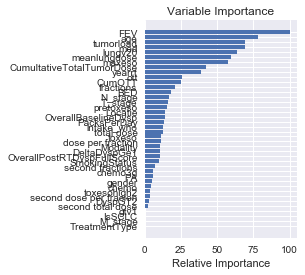

Index(['TreatmentType', 'M_stage', 'IsSCLC', 'gtv1', 'second total dose',
       'DyspGT2', 'second dose per fracion', 'toxesohigh2', 'chemo', 'gender',
       'PA', 'chemo3g', 'second fractions', 'SmokingStatus',
       'OverallPostRTDyspFullScore', 'DeltaDyspGe1', 'Modality',
       'dose per fraction', 'toxeso', 'total dose', 'intake_who',
       'PacksPerDay', 'OverallBaselineDysp', 'Locatie', 'pretoxeso', 'T_stage',
       'N_stage', 'BED', 'fractions', 'CumOTT', 'ott', 'yearrt',
       'CumultativeTotalTumorDose', 'maxeso', 'meanlungdose', 'lungv20', 'med',
       'tumorload', 'age', 'FEV'],
      dtype='object')


Index(['TreatmentType', 'M_stage', 'IsSCLC', 'gtv1', 'second total dose',
       'DyspGT2', 'second dose per fracion', 'toxesohigh2', 'chemo', 'gender',
       'PA', 'chemo3g', 'second fractions', 'SmokingStatus',
       'OverallPostRTDyspFullScore', 'DeltaDyspGe1', 'Modality',
       'dose per fraction', 'toxeso', 'total dose', 'intake_who',
       'PacksPerDay', 'OverallBaselineDysp', 'Locatie', 'pretoxeso', 'T_stage',
       'N_stage', 'BED', 'fractions', 'CumOTT', 'ott', 'yearrt',
       'CumultativeTotalTumorDose', 'maxeso', 'meanlungdose', 'lungv20', 'med',
       'tumorload', 'age', 'FEV'],
      dtype='object')

In [139]:
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance',
          'subsample': 0.5
         }
def run_boosting (params):
    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X, Y)

    score = recall_score(clf, X, Y)

    feature_importance = clf.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()

    sorted_col = X.columns[sorted_idx]
    print(sorted_col)
    return sorted_col
    
run_boosting(params)

In [140]:
reduced_col = sorted_col[10:]

X = df[reduced_col]

for alpha in alpha_nums:
    change_regularization(alpha, 'l1')
    
print(f'Maximum Score: {max_score}')
print(f'Lambda: {best_alpha}\n')

# this cell broken right now

NameError: name 'sorted_col' is not defined

In [ ]:
max_score = 0
best_alpha = 0

for alpha in alpha_nums:
    change_regularization(alpha, 'l2')
    
print(f'Maximum Score: {max_score}')
print(f'Lambda: {best_alpha}\n')